In [1]:
setwd('/import/hd/')

In [2]:
sce = readRDS('./SCE.rds')

In [3]:
table(sce$orig.ident)

Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.2.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)




  N2  OA7 
1308 2982 

In [4]:
Idents(sce) = 'orig.ident'

Loading required package: Seurat

Warning message:
"package 'Seurat' was built under R version 4.2.3"


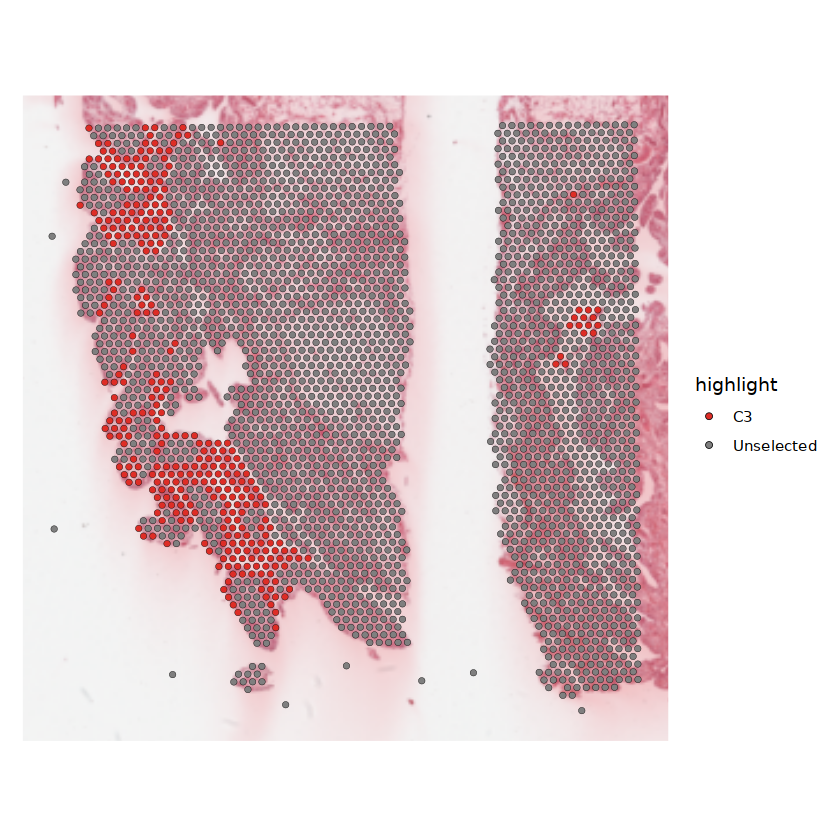

In [5]:
OA7 = subset(sce,ident = 'OA7')
OA7@images$slice1.1.1 = NULL
Idents(OA7) ='seurat_clusters'
OA7$celltype = paste0('C',OA7$seurat_clusters)
Idents(OA7) ='celltype'
SpatialDimPlot(OA7, cells.highlight = CellsByIdentities(object = OA7, idents = c('C3'))) 

In [28]:
Idents(OA7) = 'seurat_clusters'

In [29]:
cortex <- subset(OA7, idents = c(1, 2, 3,  7))

In [ ]:
data.input = GetAssayData(OA7, slot = "data", assay = "SCT")

meta = data.frame(labels = Idents(OA7), row.names = names(Idents(OA7)))

visium.brain = OA7

spatial.locs = GetTissueCoordinates(visium.brain, scale = NULL, cols = c("imagerow", "imagecol")) 

scale.factors = jsonlite::fromJSON(txt = file.path("/import/hd/OA7/spatial", 'scalefactors_json.json'))
scale.factors = list(spot.diameter = 65, spot = scale.factors$spot_diameter_fullres, # these two information are required
                     fiducial = scale.factors$fiducial_diameter_fullres, hires = scale.factors$tissue_hires_scalef, lowres = scale.factors$tissue_lowres_scalef # these three information are not required
)


In [42]:
library(CellChat)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [43]:
cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels",
                           datatype = "spatial", coordinates = spatial.locs, scale.factors = scale.factors)

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial imaging data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  C7 C6 C1 C11 C2 C3 C4 C5 C0 C8 C9 C10 


In [74]:
CellChatDB <- CellChatDB.human

In [45]:
#CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 

In [75]:
CellChatDB.use = CellChatDB

In [76]:
cellchat@DB <- CellChatDB.use

In [ ]:
library(future)

cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
plan(multisession, workers=20)

cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

cellchat <- projectData(cellchat, PPI.human)

cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1, 
                               distance.use = TRUE, interaction.length = 200, scale.distance = 0.01)

cellchat <- filterCommunication(cellchat, min.cells = 3)

cellchat <- computeCommunProbPathway(cellchat)

cellchat <- aggregateNet(cellchat)

groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = rowSums(cellchat@net$count), weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = rowSums(cellchat@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [73]:
p1 <- netVisual_heatmap(cellchat, measure = "count", color.heatmap = "Blues")
p2 <- netVisual_heatmap(cellchat, measure = "weight", color.heatmap = "Blues")
p1 + p2

Do heatmap based on a single object 




ERROR: Error in if (n <= length(colorSpace)) {: argument is of length zero


In [ ]:
par(mfrow=c(1,1), xpd = TRUE)# xpd = TRUE以显示标题
pathways.show <- c("SPP1")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
 
#在空间转录组学上显示信号网络
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "spatial", edge.width.max = 2,vertex.size.max = 1, alpha.image = 0.2, vertex.label.cex = 3.5)

In [71]:
getwd()

[1] "/import/hd"

In [74]:
packageVersion('CellChat')

[1] '1.6.1'